In [212]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf

In [213]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [214]:
# Load Data
company = 'EOS-USD'

start = dt.datetime(2021, 12, 1)
end = dt.datetime(2022, 1, 1)

# data = web.DataReader(company, 'yahoo', start, end)

data = yf.Ticker(company)
data = data.history(interval="5m",start=start,end=end)
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-11-30 21:00:00+00:00,4.043400,4.047701,4.040965,4.047701,0,0,0
2021-11-30 21:05:00+00:00,4.045142,4.045142,4.038349,4.039146,0,0,0
2021-11-30 21:10:00+00:00,4.033266,4.040954,4.033266,4.040954,0,0,0
2021-11-30 21:15:00+00:00,4.044600,4.044981,4.036953,4.036953,88384,0,0
2021-11-30 21:20:00+00:00,4.034073,4.034073,4.032675,4.032675,0,0,0
...,...,...,...,...,...,...,...
2021-12-31 20:35:00+00:00,2.998818,2.998818,2.994495,2.995187,0,0,0
2021-12-31 20:40:00+00:00,2.994302,2.994302,2.992373,2.992373,523680,0,0
2021-12-31 20:45:00+00:00,2.992504,2.992504,2.991284,2.991284,0,0,0


In [215]:
# Prepare Data

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
predictio_days = 60

X_train = []
y_train = []

for x in range(predictio_days, len(scaled_data)):
    X_train.append(scaled_data[x-predictio_days:x, 0])
    y_train.append(scaled_data[x, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 

In [216]:
# Build The Model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next close

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
276/276 [==============================] - 24s 61ms/step - loss: 0.0087
Epoch 2/25
276/276 [==============================] - 18s 65ms/step - loss: 0.0025
Epoch 3/25
276/276 [==============================] - 16s 59ms/step - loss: 0.0024
Epoch 4/25
276/276 [==============================] - 16s 59ms/step - loss: 0.0019
Epoch 5/25
276/276 [==============================] - 13s 47ms/step - loss: 0.0017
Epoch 6/25
276/276 [==============================] - 13s 47ms/step - loss: 0.0014
Epoch 7/25
276/276 [==============================] - 13s 47ms/step - loss: 0.0013
Epoch 8/25
276/276 [==============================] - 13s 47ms/step - loss: 0.0011
Epoch 9/25
276/276 [==============================] - 15s 53ms/step - loss: 0.0010
Epoch 10/25
276/276 [==============================] - 17s 61ms/step - loss: 9.1177e-04
Epoch 11/25
276/276 [==============================] - 13s 47ms/step - loss: 8.2949e-04
Epoch 12/25
276/276 [==============================] - 13s 47ms/step - loss: 

Test The Model Accuracy on Existing Data

In [217]:
# Load Test Data

test_start = dt.datetime(2022,1,1)
test_end= dt.datetime.now()

test_data = yf.Ticker(company)
test_data = test_data.history(interval="5m",start=test_start,end=test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - predictio_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)


In [218]:
# Make Predictions on Test Data

x_test = []

for x in range(predictio_days, len(model_inputs)):
    x_test.append(model_inputs[x-predictio_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)

predicted_prices = scaler.inverse_transform(predicted_prices)

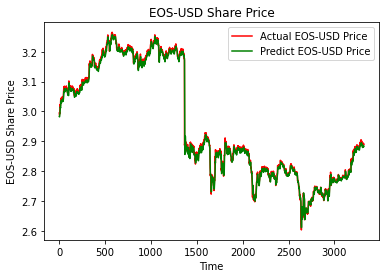

In [219]:
# Plot The Test Predictions

plt.plot(actual_prices, color="red", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predict {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [223]:
# Predict Next Candle

real_data = [model_inputs[len(model_inputs) + 1 - predictio_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[2.8825717]]
